In [79]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D

In [80]:
random.seed(1314)

def Mean(data):
    return np.mean(data,axis=1)

def Std(data):
    return np.std(data,axis=1)

def Var(data):
    return np.var(data,axis=1)

def Skew(data):
    return stats.skew(data,axis=1)

def Kurtosis(data):
    return stats.kurtosis(data,axis=1)

In [81]:
random_data1 = (np.random.normal(20,4,50000)).reshape(5000,10,1)
random_data2 = (np.random.normal(50,20,200000)).reshape(20000,10,1)
random_data3 = (np.random.normal(100,70,200000)).reshape(20000,10,1)
random_data4 = (np.random.normal(500,250,200000)).reshape(20000,10,1)
random_data5 = (np.random.normal(1000,800,200000)).reshape(20000,10,1)
random_data6 = (np.random.normal(1000,20,200000)).reshape(20000,10,1)
random_data7 = (np.random.normal(1000,4,200000)).reshape(20000,10,1)


data = np.concatenate( (random_data1,random_data2) )
data = np.concatenate( (data,random_data3) )
data = np.concatenate( (data,random_data4) )
data = np.concatenate( (data,random_data5) )
data = np.concatenate( (data,random_data6) )
data = np.concatenate( (data,random_data7) )



val_data2 = (np.random.normal(500,250,20000)).reshape(2000,10,1)


In [82]:
mean_data = Mean(data)
std_data = Std(data)
skew_data = Skew(data)
kurtosis_data = Kurtosis(data)

mean_datav = Mean(val_data2)
std_datav = Std(val_data2)
skew_datav = Skew(val_data2)
kurtosis_datav = Kurtosis(val_data2)

In [83]:
# preload models
stdModel = load_model('./std2.h5')
meanModel = load_model('./mean2.h5')

# Skewness

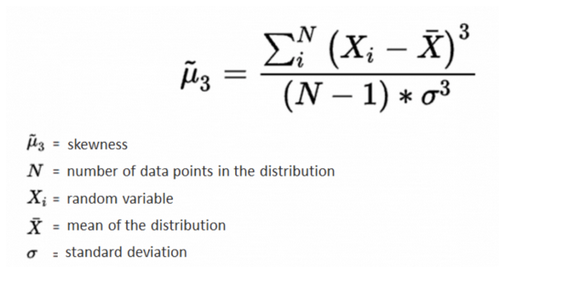

In [130]:
# code merged mean/ std as layers then output skew (not work too well)


input_layer = keras.Input(shape=(10,1))
x = Flatten()(input_layer)
#x = BatchNormalization(axis=1)(x)
# numerator
mean_1 = Dense(64, activation='relu')(x)
mean_2 = Dense(64, activation='relu')(mean_1)
mean_out = Dense(1, activation = 'relu', name = 'mean')(mean_2)

# denominator
std_1 = Dense(64, activation='relu')(x)
std_2 = Dense(64, activation='relu')(std_1)
std_out = Dense(1, activation = 'relu', name = 'std')(std_2)

n_d = concatenate([mean_out,std_out])
skew1 = Dense(128, activation='relu')(n_d)
skew2 = Dense(128, activation='relu')(skew1)
skew3 = Dense(128, activation='relu')(skew2)

skew_out = Dense(1, activation = 'linear', name= 'skewness')(skew3)

skewModel = keras.Model(input_layer, [mean_out,std_out,skew_out ], name= "skew")

In [131]:
skewModel.compile(optimizer="adam", loss="mean_squared_error")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [85]:
skewModel.summary()

Model: "skew"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 10)           0           input_14[0][0]                   
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 64)           704         flatten_13[0][0]                 
__________________________________________________________________________________________________
dense_95 (Dense)                (None, 64)           704         flatten_13[0][0]                 
_______________________________________________________________________________________________

In [86]:
# standard DL

# skewModel = Sequential([
# keras.layers.Flatten(input_shape=(10,1)),
# Dense(128,activation='relu'),
# Dense(128,activation='relu'),
# Dense(64,activation='relu'),
# Dense(64,activation='relu'),           

# Dense(32, activation ='relu'),
# Dense(1, activation ='linear')
# ])

In [101]:

# skewModel.fit(random_data2, [mean_data2,std_data2,skew_data2 ], 
#               #validation_data=([val_data2,[mean_data2v,std_data2v,skew_data2v]]), 
#               epochs=1000, batch_size=128,
#           #  callbacks=[es],
#                 shuffle=True)


#skewModel.fit(random_data2, [mean_data2,std_data2,skew_data2 ], epochs=1000, batch_size=128)

In [151]:
# code train mean model first, std second, and call the models to train skew

# mean model
meanModel = Sequential([
keras.layers.Flatten(input_shape=(10,1)),
Dense(64,activation='relu'),
Dense(64,activation='relu'),
Dense(1, activation ='linear')
])

In [104]:
# meanModel.compile(optimizer="adam", loss="mean_squared_error")
# meanModel.fit(data, mean_data, 
#               epochs=1000, batch_size=128,
#                 shuffle=True)

In [184]:
# std model

stdModel = Sequential([
keras.layers.Flatten(input_shape=(10,1)),
Dense(64,activation='relu'),
Dense(128,activation='relu'),
Dense(64,activation='relu'),
Dense(32,activation='relu'),
Dense(1, activation ='linear')
])

In [103]:
# stdModel.compile(optimizer="adam", loss="mean_squared_error")
# stdModel.fit(data, std_data, 
#               epochs=1000, batch_size=128,
#                 shuffle=True)

In [109]:
input_layer = keras.Input(shape=(10,1))
x = Flatten()(input_layer)
#x = BatchNormalization(axis=1)(x)
# numerator
numerator = meanModel(x)
denum = stdModel(x)

n_d = concatenate([numerator,denum])

skew1 = Dense(64, activation='relu')(n_d)
skew2 = Dense(64, activation='relu')(skew1)


skew_out = Dense(1, activation = 'linear', name= 'skewness')(skew2)



skewModel = keras.Model(input_layer, skew_out, name= "skew")

In [141]:
skewModel.compile(optimizer="adam", loss="mean_squared_error")
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)

In [102]:
# skewModel.fit(data, skew_data,
#              # validation_data=(val_data2,skew_datav), 
#               epochs=1000,
#               #callbacks=[es],
#               batch_size=128, shuffle=True)

1/1 [==============================] - 0s 21ms/step


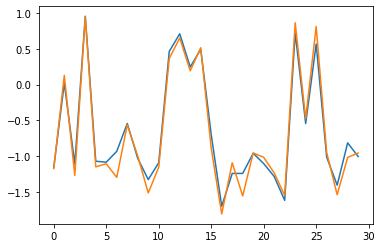

In [99]:
Predirect_arr2 = (np.random.normal(1000,2040,300)).reshape(30,10,1)
# plt.plot(range(30),Skew(Predirect_arr2),range(30), skewModel.predict(Predirect_arr2))

#method 1 testing
# plt.plot(range(30),np.mean(Predirect_arr2, axis=1),range(30), skewModel.predict(Predirect_arr2)[0])
# plt.plot(range(30),np.std(Predirect_arr2, axis=1),range(30), skewModel.predict(Predirect_arr2)[1])
#plt.plot(range(30),Skew(Predirect_arr2),range(30), skewModel.predict(Predirect_arr2)[2])

#method 2 testing
#plt.plot(range(30),np.mean(Predirect_arr2, axis=1),range(30), meanModel.predict(Predirect_arr2))
#plt.plot(range(30),np.std(Predirect_arr2, axis=1),range(30), stdModel.predict(Predirect_arr2))
#plt.plot(range(30),Skew(Predirect_arr2),range(30), skewModel.predict(Predirect_arr2))
plt.plot(range(30),Kurtosis(Predirect_arr2),range(30), kurtosisModel.predict(Predirect_arr2))

In [100]:
#skewModel.save("./skew2.h5")
#meanModel.save("./mean2.h5")
#stdModel.save("./std2.h5")
#kurtosisModel.save("./kurtosisModel2.h5")

# Kurtosis

In [84]:
input_layer = keras.Input(shape=(10,1))
x = Flatten()(input_layer)
#x = BatchNormalization(axis=1)(x)
# numerator
numerator = meanModel(x)
denum = stdModel(x)

n_d = concatenate([numerator,denum])

kurtosis1 = Dense(64, activation='relu')(n_d)
kurtosis2 = Dense(128, activation='relu')(kurtosis1)
kurtosis3 = Dense(64, activation='relu')(kurtosis2)


kurtosis_out = Dense(1, activation = 'linear', name= 'kurtosis')(kurtosis3)



kurtosisModel = keras.Model(input_layer, kurtosis_out, name= "kurtosis")

In [85]:
kurtosisModel.compile(optimizer="adam", loss="mean_squared_error")

In [101]:
# kurtosisModel.fit(data, kurtosis_data,
#              # validation_data=(val_data2,skew_datav), 
#               epochs=1000,
#               #callbacks=[es],
#               batch_size=128, shuffle=True)